In [1]:
from keras.models import load_model
model = load_model('seti_small_1.h5')
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [2]:
img_path = "../data/primary_small/test/squigglesquarepulsednarrowband/2155_squigglesquarepulsednarrowband.png"
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


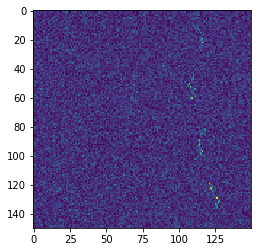

In [3]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs=layer_outputs)

In [5]:
activations = activation_model.predict(img_tensor)

In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


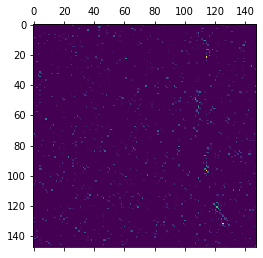

In [7]:
plt.matshow(first_layer_activation[0, :, :,1], cmap='viridis')

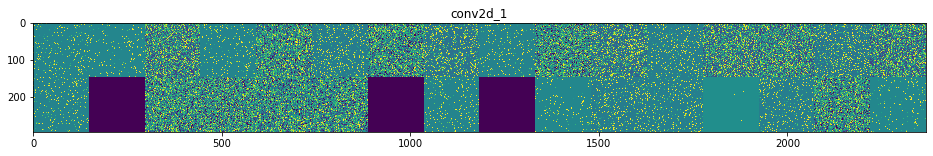

In [37]:
layer_names = []
for layer in model.layers[:1]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [40]:
from keras.applications import VGG16
from keras import backend as K

layer_name = 'conv2d_4'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [41]:
grads = K.gradients(loss, model.input)[0]

In [42]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [43]:
iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [46]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [48]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [51]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input) [0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

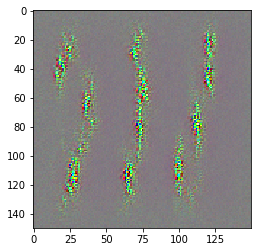

In [67]:
plt.imshow(generate_pattern('conv2d_4', 2))

In [73]:
layer_name = 'conv2d_1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

ValueError: slice index 32 of dimension 3 out of bounds. for 'strided_slice_41' (op: 'StridedSlice') with input shapes: [?,148,148,32], [4], [4], [4] and with computed input tensors: input[1] = <0 0 0 32>, input[2] = <0 0 0 33>, input[3] = <1 1 1 1>.